EGG synthesis

Model: Transformer might not be necessary, since the input and output are of the same length. A simple feed-forward network might be enough.

X: (a)raw audio signal, 16kHz, (batch_size, time_frames)
   (b)spectrograms, 16kHz, (batch_size, frequency_bins, time_frames)
   (c)MFCCs,  16kHz, (batch_size, frequency_bins, time_frames)
Y: (a) EGG signal waveform, 16kHz
   (b) metrics, 50Hz
   (c) Fourier descriptors, 50Hz

Loss function: MSE works fine with test, but not others
               Cosine similarity works fine with mapping the shape, but not the amplitude
               DTW works bad here.

Comments:
since I use metrics as reference, it's probably better to use metrics as output as well.

Environment Setup

In [19]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import librosa
import itertools
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, Dataset

# hyperparameters
samplerate = 16000
num_epochs = 300
hidden_size = 256
second_hidden_size = 256
third_hidden_size = 256
learning_rate = 0.001
segment_length_in_seconds = 0.005
top_db = 30
segment_length_in_samples = int(segment_length_in_seconds * samplerate)
max_length = samplerate
batch_size = 32

adult_directory = r'F:\A2E\adults-trimmed'
child_directory = r'F:\A2E\children-trimmed'

# for mel spectrogram parameters
n_mels = 16
n_fft = 1024
hop_length = 256

Data set building

In [2]:
class VoiceDataset(Dataset):
    def __init__(self, segment_length_in_samples):
        """
        Initialize the VoiceDataset class.

        Args:
            segment_length_in_samples (int): Length of audio segments.
        """
        self.data = None
        self.segments = None
        self.length = None
        self.segment_length_samples = segment_length_in_samples
        
    def load_dataset(self, dataset_name, samplerate):
        ''' load the dataset
        Args:
            dataset_name (str): Name of the dataset.
            samplerate (int): Sample rate of the audio data.
        Returns:
            numpy.ndarray: Audio data. '''
        if dataset_name == 'test':
            file_dir = r'F:\A2E\test file\test_Voice_EGG.wav'
            wav_data, sr = librosa.load(file_dir, sr=samplerate, mono=False)
        elif dataset_name == 'one_singing':
            file_dir1 = r'F:\A2E\adults-trimmed\F01\190306_095129_F01_VRP1_C_Voice_EGG.wav'
            file_dir2 = r'F:\A2E\adults-trimmed\F01\190306_095940_F01_VRP2_C_Voice_EGG.wav'
            wav1, sr = librosa.load(file_dir1, sr=samplerate, mono=False)
            wav2, sr = librosa.load(file_dir2, sr=samplerate, mono=False)
            wav_data = np.concatenate([wav1, wav2], axis=1)
        elif dataset_name == 'one_reading':
            file_dir1 = r'F:\A2E\adults-trimmed\F01\190306_094138_F01_SRP1_C_Voice_EGG.wav'
            file_dir2 = r'F:\A2E\adults-trimmed\F01\190306_094516_F01_SRP2_C_Voice_EGG.wav'
            file_dir3 = r'F:\A2E\adults-trimmed\F01\190306_094802_F01_SRP3_C_Voice_EGG.wav'
            wav1, sr = librosa.load(file_dir1, sr=samplerate, mono=False)
            wav2, sr = librosa.load(file_dir2, sr=samplerate, mono=False)
            wav3, sr = librosa.load(file_dir3, sr=samplerate, mono=False)
            wav_data = np.concatenate([wav1, wav2, wav3], axis=1)
        elif dataset_name == 'one_everything':
            file_dir1 = r'F:\A2E\adults-trimmed\F01\190306_095129_F01_VRP1_C_Voice_EGG.wav'
            file_dir2 = r'F:\A2E\adults-trimmed\F01\190306_095940_F01_VRP2_C_Voice_EGG.wav'
            file_dir3 = r'F:\A2E\adults-trimmed\F01\190306_094138_F01_SRP1_C_Voice_EGG.wav'
            file_dir4 = r'F:\A2E\adults-trimmed\F01\190306_094516_F01_SRP2_C_Voice_EGG.wav'
            file_dir5 = r'F:\A2E\adults-trimmed\F01\190306_094802_F01_SRP3_C_Voice_EGG.wav'
            wav1, sr = librosa.load(file_dir1, sr=samplerate, mono=False)
            wav2, sr = librosa.load(file_dir2, sr=samplerate, mono=False)
            wav3, sr = librosa.load(file_dir3, sr=samplerate, mono=False)
            wav4, sr = librosa.load(file_dir4, sr=samplerate, mono=False)
            wav5, sr = librosa.load(file_dir5, sr=samplerate, mono=False)
            wav_data = np.concatenate([wav1, wav2, wav3, wav4, wav5], axis=1)
        elif dataset_name == 'all_singing':
            temp = []
            for root, dirs, files in os.walk(adult_directory):
                for file in files:
                    # Check if the file ends with 'Voice_EGG.wav' and contains 'VRP'
                    if file.endswith('Voice_EGG.wav') and 'VRP' in file:
                        # Construct the full file path
                        file_path = os.path.join(root, file)
                        audio_data, sample_rate = librosa.load(file_path, sr=samplerate, mono=False)
                        # Append the audio data to the list
                        temp.append(audio_data)
            wav_data = np.concatenate(temp, axis=1)
        elif dataset_name == 'all_reading':
            temp = []
            for root, dirs, files in os.walk(adult_directory):
                for file in files:
                    # Check if the file ends with 'Voice_EGG.wav' and contains 'SRP'
                    if file.endswith('Voice_EGG.wav') and 'SRP' in file:
                        # Construct the full file path
                        file_path = os.path.join(root, file)
                        audio_data, sample_rate = librosa.load(file_path, sr=samplerate, mono=False)
                        # Append the audio data to the list
                        temp.append(audio_data)
            wav_data = np.concatenate(temp, axis=1)
        elif dataset_name == 'all_everything':
            temp = []
            for root, dirs, files in os.walk(adult_directory):
                for file in files:
                    # Check if the file ends with 'Voice_EGG.wav'
                    if file.endswith('Voice_EGG.wav'):
                        # Construct the full file path
                        file_path = os.path.join(root, file)
                        audio_data, sample_rate = librosa.load(file_path, sr=samplerate, mono=False)
                        # Append the audio data to the list
                        temp.append(audio_data)
            wav_data = np.concatenate(temp, axis=1)
        else:
            raise ValueError('Invalid dataset name.')
        return wav_data

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        segment = self.segments[idx]

        # Convert to tensors
        input_tensor = torch.tensor(segment[0], dtype=torch.float32)
        target_tensor = torch.tensor(segment[1], dtype=torch.float32)

        # Ensure tensors have correct shape
        assert input_tensor.shape == (self.segment_length_samples, n_mels)
        assert target_tensor.shape == (self.segment_length_samples, n_mels)

        return input_tensor, target_tensor

    def _remove_silence(self, wav):
        # remove silence in the first channel
        non_silent_intervals = librosa.effects.split(wav[0], top_db=top_db)
        # Apply these intervals to both channels
        non_silent_wavs = []
        for channel in range(wav.shape[0]):  # Assuming wav has shape (channels, samples)
            channel_data = wav[channel]
            # Applying the same non-silent intervals to each channel
            non_silent_channel_wav = np.concatenate([channel_data[interval[0]:interval[1]] for interval in non_silent_intervals])
            non_silent_wavs.append(non_silent_channel_wav)        
        
        non_silent_wav = np.array(non_silent_wavs)
        return non_silent_wav
    
    def _min_max_normalization(self, wav):
        # min-max normalization for each channel separately
        for i in range(wav.shape[0]):
            wav[i] = (wav[i] - wav[i].min()) / (wav[i].max() - wav[i].min())
        return wav
    
    def _segment(self, wav):
        paired_segments = []
        if isinstance(wav, list):
            for spectrogram in wav:
                # Assuming spectrogram shape is [n_mels, time_frames]
                num_segments = (spectrogram.shape[1] - self.segment_length_samples + 1) // self.segment_length_samples
                print(f"Spectrogram length: {spectrogram.shape[1]}, segment_length_samples: {self.segment_length_samples}, calculated num_segments: {num_segments}")
                if num_segments <= 0:
                    continue  # No segments can be created
                for i in range(num_segments):
                    start_idx = i * self.segment_length_samples
                    end_idx = start_idx + self.segment_length_samples
                    segment = spectrogram[:, start_idx:end_idx]
                    # Transpose to get [sequence_length, n_mels]
                    paired_segments.append((segment.T, segment.T))
        else:
            # Handle raw audio (original implementation)
            paired_segments = []
            num_segments = (wav.shape[1] - self.segment_length_samples + 1) // self.segment_length_samples
            for i in range(num_segments):
                start_idx = i * self.segment_length_samples
                end_idx = start_idx + self.segment_length_samples
                segment_1 = wav[0, start_idx:end_idx]
                segment_2 = wav[1, start_idx:end_idx]
                paired_segments.append((segment_1, segment_2))

        return paired_segments



    def _pad_audio(self, segment):
        # Pad the segment to the desired length if necessary
        padding_length = self.segment_length_samples - len(segment)
        if padding_length > 0:
            padding = np.zeros(padding_length)
            segment = np.concatenate((segment, padding))
        return segment


    def create_segments(self, wav):
        # Create and process segments
        segments = self._segment(wav)
        print(f"Number of created segments: {len(segments)}")
        return [(self._pad_audio(segment[0]), self._pad_audio(segment[1])) for segment in segments]


    def preprocess(self, wav, preprocess_type = 'pure_signal_process'):
        ''' general preprocessing
         Returns:
            numpy.ndarray: Preprocessed audio data. '''
        # remove silence
        wav = self._remove_silence(wav)
        # min-max normalization
        wav = self._min_max_normalization(wav)

        if preprocess_type == 'pure_signal_process':
            # create segments
            self.segments = self.create_segments(wav)
            self.length = len(self.segments)

        elif preprocess_type == 'spectrogram_process':
            wav = self.spectrogram_process(wav)
            print(f"Number of spectrograms: {len(wav)}")
            if wav:
                print(f"Shape of first spectrogram: {wav[0].shape}")
            self.segments = self.create_segments(wav)
            self.length = len(self.segments)

        elif preprocess_type == 'MFCC_process':
            pass
        elif preprocess_type == 'fourier_descriptor_process':
            pass
               
        return wav
      
    def plot(self, wav):
        # plot the wav for visualization, first channel then second channel
        plt.figure(figsize=(16, 4))
        plt.plot(wav[0])
        plt.title('Acoustic')
        plt.show()
        plt.figure(figsize=(16, 4))
        plt.plot(wav[1])
        plt.title('EGG')
        plt.show()
        
    def check_shape(self, wav):
        # check the shape of the wav
        print(wav.shape)
    
    def split_data(self, train_ratio=0.7, val_ratio=0.15):
        total_segments = len(self.segments)
        train_end = int(total_segments * train_ratio)
        val_end = train_end + int(total_segments * val_ratio)

        train_segments = self.segments[:train_end]
        val_segments = self.segments[train_end:val_end]
        test_segments = self.segments[val_end:]

        return train_segments, val_segments, test_segments
    
    def pure_signal_process(self, wav):
        return wav
    
    def spectrogram_process(self, wav, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, convert_to_db=True):
        # Process each channel separately
        spectrograms = []
        for channel in range(wav.shape[0]):
            # Calculate STFT
            stft = librosa.stft(wav[channel], n_fft=n_fft, hop_length=hop_length)
            
            # Convert to magnitude spectrogram
            magnitude = np.abs(stft)
            
            # Convert to Mel scale
            mel_spectrogram = librosa.feature.melspectrogram(S=magnitude**2, sr=samplerate, n_mels=n_mels)

            # Apply logarithmic scaling
            if convert_to_db:
                mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)
            else:
                mel_spectrogram_db = mel_spectrogram

            spectrograms.append(mel_spectrogram_db)
        
        # # plot the spectrogram for visualization, first channel then second channel
        # plt.figure(figsize=(16, 4))
        # plt.imshow(spectrograms[0], origin='lower')
        # plt.title('Acoustic')
        # plt.show()
        # plt.figure(figsize=(16, 4))
        # plt.imshow(spectrograms[1], origin='lower')
        # plt.title('EGG')
        # plt.show()
        return spectrograms
    
    def MFCC_process(self, wav):
        return wav
    
    def fourier_descriptor_process(self, wav):
        return wav

In [20]:
# create the dataset
dataset = VoiceDataset(segment_length_in_samples)
wav_data = dataset.load_dataset('one_everything', samplerate)
dataset.preprocess(wav_data, preprocess_type='pure_signal_process')

train_segments, val_segments, test_segments = dataset.split_data(train_ratio=0.7, val_ratio=0.15)

# create the dataloader
train_loader = DataLoader(train_segments, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_segments, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_segments, batch_size=batch_size, shuffle=False)

# check the shape of the loader
for batch in train_loader:
    print(batch[0].shape, batch[1].shape)
    break

Number of created segments: 33003
torch.Size([32, 80]) torch.Size([32, 80])


In [14]:
class FeedforwardNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, second_hidden_size, third_hidden_size, fourth_hidden_size, output_size, dropout_prob=0.5):
        super(FeedforwardNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, second_hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.fc3 = nn.Linear(second_hidden_size, third_hidden_size)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout_prob)
        self.fc4 = nn.Linear(third_hidden_size, output_size)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(p=dropout_prob)
        self.fc5 = nn.Linear(output_size, output_size)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.fc5(x)
        return x
    
class Seq2SeqCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, kernel_size, num_layers, dropout_prob=0.5):
        super(Seq2SeqCNN, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
    
        # Convolutional layers for encoding
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=hidden_size, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )

        # Convolutional layers for decoding
        self.decoder = nn.Sequential(
            nn.Conv1d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Conv1d(in_channels=hidden_size, out_channels=output_size, kernel_size=kernel_size, padding=kernel_size // 2)
        )

    def forward(self, x):
        # Reshape input for CNN: [batch_size, features, sequence_length]
        x = x.transpose(1, 2)

        # Encoding
        encoded = self.encoder(x)

        # Decoding
        decoded = self.decoder(encoded)

        # Reshape output to original shape: [batch_size, sequence_length, features]
        output = decoded.transpose(1, 2)

        return output

In [13]:
# for mel spectrogram
class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=False)
        self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=False) 
        self.fc = nn.Linear(hidden_size, output_size)  # Maps hidden state to output size (Mel frequency bands)
        self.dropout = nn.Dropout(dropout_prob)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Maps fc output to decoder input size (1)
        self.decoder_input_layer = nn.Linear(output_size, hidden_size)  # Correct the mapping size

    def forward(self, x):
        # Reshape input to [seq_len, batch_size, input_size]
        x = x.transpose(0, 1)

        # Encoding
        encoder_outputs, (hidden, cell) = self.encoder(x)

        # Prepare the first input to the decoder which will be the last hidden state of the encoder
        decoder_input = hidden[-1]  # Take the last layer's hidden state for all batches

        # Initialize the decoder hidden state as the last encoder hidden state
        decoder_hidden = hidden
        decoder_cell = cell

        # Decoding
        decoder_outputs = []
        for t in range(x.size(0)):  # Iterate over time steps
            # Decode step by step
            decoder_output, (decoder_hidden, decoder_cell) = self.decoder(
                decoder_input.unsqueeze(0), (decoder_hidden, decoder_cell))
            out = self.fc(self.dropout(decoder_output.squeeze(0)))
            decoder_outputs.append(out)
            # Transform the output size to match the decoder input size using the decoder input layer
            decoder_input = self.decoder_input_layer(out)

        # Stack outputs along the sequence dimension
        outputs = torch.stack(decoder_outputs, dim=0).transpose(0, 1)

        return outputs


Training

In [ ]:
# waveform cross entropy loss
class WaveformCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(WaveformCrossEntropyLoss, self).__init__()

    def forward(self, outputs, targets):
        # Apply softmax to the predicted waveform
        q_x = F.softmax(outputs, dim=1)
        # Calculate the log probabilities of the predicted waveform
        log_q_x = torch.log(q_x)
        # Compute the cross-entropy loss
        wce_loss = -torch.sum(targets * log_q_x)
        return wce_loss

model = FeedforwardNetwork(input_size=segment_length_in_samples, hidden_size=hidden_size, second_hidden_size=second_hidden_size, output_size=segment_length_in_samples, dropout_prob=0.5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = WaveformCrossEntropyLoss() 

# Training loop
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    for inputs, targets in val_loader:
        with torch.no_grad():
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(val_loader)
    print(f'Epoch: {epoch + 1}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')

Epoch: 1/300, Training Loss: 0.0116, Validation Loss: 0.0046, LR: 0.001
Epoch: 2/300, Training Loss: 0.0060, Validation Loss: 0.0047, LR: 0.001
Epoch: 3/300, Training Loss: 0.0054, Validation Loss: 0.0046, LR: 0.001
Epoch: 4/300, Training Loss: 0.0052, Validation Loss: 0.0046, LR: 0.001
Epoch: 5/300, Training Loss: 0.0050, Validation Loss: 0.0046, LR: 0.001
Epoch: 6/300, Training Loss: 0.0049, Validation Loss: 0.0046, LR: 0.001
Epoch: 7/300, Training Loss: 0.0048, Validation Loss: 0.0046, LR: 0.001
Epoch: 8/300, Training Loss: 0.0048, Validation Loss: 0.0046, LR: 0.001
Epoch: 9/300, Training Loss: 0.0048, Validation Loss: 0.0046, LR: 0.001
Epoch: 10/300, Training Loss: 0.0047, Validation Loss: 0.0046, LR: 0.001
Epoch: 11/300, Training Loss: 0.0047, Validation Loss: 0.0046, LR: 0.001
Epoch: 12/300, Training Loss: 0.0047, Validation Loss: 0.0046, LR: 0.001
Epoch: 13/300, Training Loss: 0.0047, Validation Loss: 0.0046, LR: 0.001
Epoch 00014: reducing learning rate of group 0 to 1.0000e-04

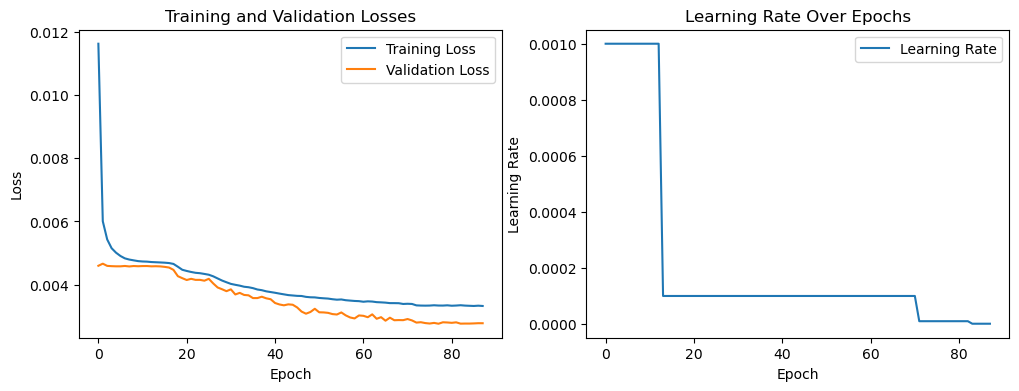

In [21]:
# FNN training
model = FeedforwardNetwork(input_size=segment_length_in_samples, hidden_size=hidden_size, second_hidden_size=second_hidden_size,
                            third_hidden_size=third_hidden_size, fourth_hidden_size=third_hidden_size, output_size=segment_length_in_samples, dropout_prob=0.2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)

best_val_loss = float('inf')
patience = 10  # Adjust as needed
patience_counter = 0

train_losses = []
val_losses = []
lr_rates = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lr_rates.append(current_lr)

    print(f'Epoch: {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, LR: {current_lr}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model checkpoint if desired
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Plotting the training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lr_rates, label='Learning Rate')
plt.title("Learning Rate Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.legend()
plt.show()


Epoch 1, Batch 1: Input Shape - torch.Size([32, 800, 16]), Target Shape - torch.Size([32, 800, 16])
Epoch 1: Training Loss: 4462.2693, Validation Loss: 5062.0120, Learning Rate: 0.01
Epoch 2: Training Loss: 5242.2892, Validation Loss: 4872.1638, Learning Rate: 0.01
Epoch 3: Training Loss: 5144.1588, Validation Loss: 4820.7837, Learning Rate: 0.01
Epoch 4: Training Loss: 5063.0878, Validation Loss: 4797.5564, Learning Rate: 0.01
Epoch 5: Training Loss: 5049.5648, Validation Loss: 4767.7793, Learning Rate: 0.01
Epoch 6: Training Loss: 4974.2190, Validation Loss: 4672.0432, Learning Rate: 0.01
Epoch 7: Training Loss: 4825.7176, Validation Loss: 4476.5530, Learning Rate: 0.01
Epoch 8: Training Loss: 4648.1544, Validation Loss: 4307.8716, Learning Rate: 0.01
Epoch 9: Training Loss: 4499.8362, Validation Loss: 4172.4080, Learning Rate: 0.01
Epoch 10: Training Loss: 4359.7328, Validation Loss: 4031.2831, Learning Rate: 0.01
Epoch 11: Training Loss: 4231.9305, Validation Loss: 3923.5099, Learn

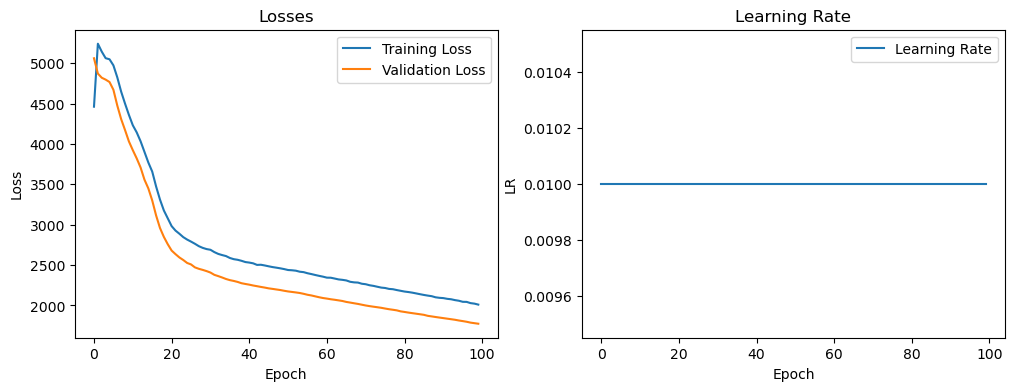

In [14]:
# MEL spectrogram training
model = Seq2SeqLSTM(input_size=n_mels, hidden_size=hidden_size, num_layers=3, output_size=n_mels, dropout_prob=0.2)

# Move the model to the appropriate device (e.g., CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, verbose=True)

# Early stopping parameters
best_val_loss = float('inf')
patience = 20
patience_counter = 0

# Lists for storing metrics
train_losses = []
val_losses = []
lr_rates = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Logging shapes for the first epoch
        if epoch == 0 and i == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}: Input Shape - {inputs.shape}, Target Shape - {targets.shape}")

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Learning rate scheduler step and log current LR
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lr_rates.append(current_lr)

    print(f"Epoch {epoch + 1}: Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Learning Rate: {current_lr}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lr_rates, label='Learning Rate')
plt.title("Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.legend()

plt.show()

Prediction

Test Loss: 0.0006
Test Loss: 0.0007
Test Loss: 0.0015
Test Loss: 0.0008
Test Loss: 0.0027
Test Loss: 0.0033
Test Loss: 0.0029
Test Loss: 0.0021
Test Loss: 0.0026
Test Loss: 0.0022
Test Loss: 0.0024
Test Loss: 0.0016
Test Loss: 0.0011
Test Loss: 0.0009
Test Loss: 0.0005
Test Loss: 0.0005
Test Loss: 0.0005
Test Loss: 0.0003
Test Loss: 0.0008
Test Loss: 0.0027
Test Loss: 0.0024
Test Loss: 0.0016
Test Loss: 0.0009
Test Loss: 0.0007
Test Loss: 0.0005
Test Loss: 0.0020
Test Loss: 0.0006
Test Loss: 0.0005
Test Loss: 0.0022
Test Loss: 0.0075
Test Loss: 0.0114
Test Loss: 0.0066
Test Loss: 0.0090
Test Loss: 0.0022
Test Loss: 0.0016
Test Loss: 0.0010
Test Loss: 0.0009
Test Loss: 0.0008
Test Loss: 0.0006
Test Loss: 0.0006
Test Loss: 0.0008
Test Loss: 0.0014
Test Loss: 0.0010
Test Loss: 0.0008
Test Loss: 0.0005
Test Loss: 0.0070
Test Loss: 0.0243
Test Loss: 0.0051
Test Loss: 0.0101
Test Loss: 0.0053
Test Loss: 0.0033
Test Loss: 0.0023
Test Loss: 0.0013
Test Loss: 0.0013
Test Loss: 0.0013
Test Loss:

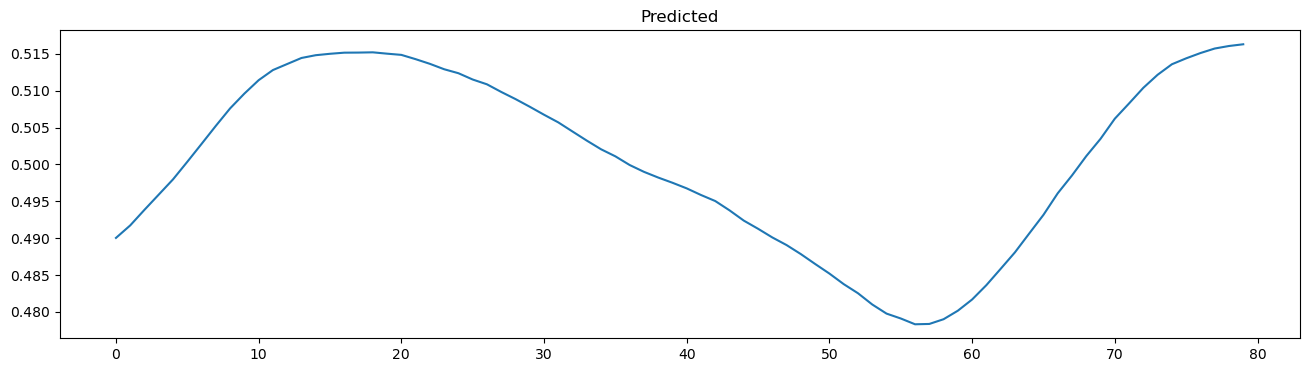

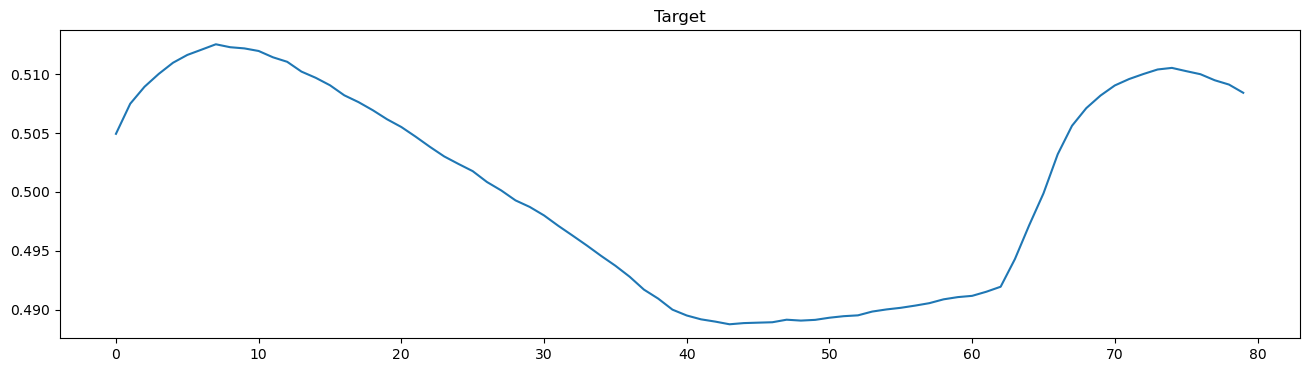

In [24]:
# predict
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets).item()
        print(f"Test Loss: {loss:.4f}")

# plot the random predicted wav for visualization
plt.figure(figsize=(16, 4))
random_index = random.randint(0, len(outputs) - 1)
plt.plot(outputs[random_index].cpu().numpy())
plt.title('Predicted')
plt.show()
plt.figure(figsize=(16, 4))
plt.plot(targets[random_index].cpu().numpy())
plt.title('Target')
plt.show()

g:\Conda\envs\pytorch\Lib\site-packages\librosa\feature\inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


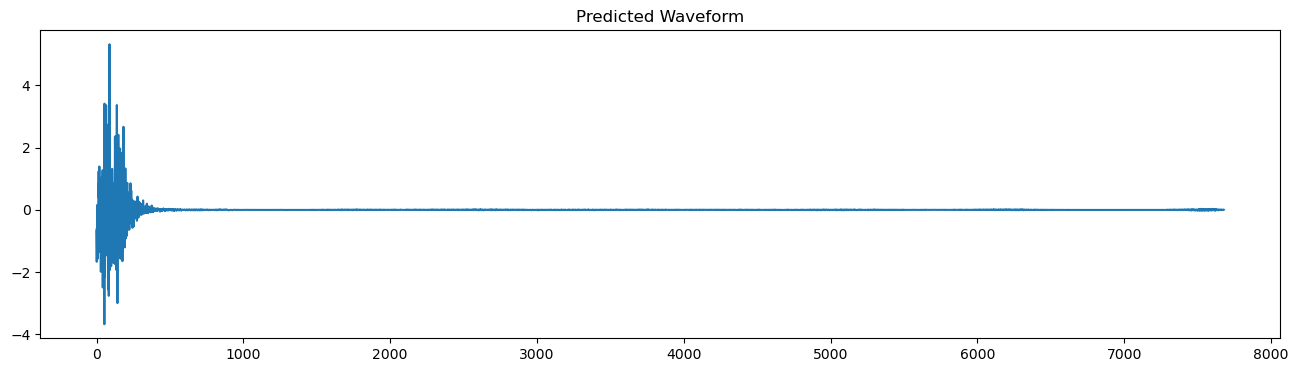

In [16]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'outputs' is your predicted Mel spectrogram in dB with shape [batch_size, n_mels, time_steps]
# Convert it back to the linear scale
mel_spec_predicted = librosa.db_to_power(outputs[0].cpu().numpy())

# Inverse Mel transformation
stft_predicted = librosa.feature.inverse.mel_to_stft(mel_spec_predicted)

# Apply Griffin-Lim algorithm to reconstruct the phase information
waveform_predicted = librosa.griffinlim(stft_predicted)

# Plot the predicted waveform for visualization
plt.figure(figsize=(16, 4))
plt.plot(waveform_predicted)
plt.title('Predicted Waveform')
plt.show()

# The same steps would apply to the target if it's also a Mel spectrogram


In [36]:
# MSE loss
# predict
model.eval()
test_loss = 0
for inputs, targets in test_loader:
    with torch.no_grad():
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')



# turn to original wav
outputs = outputs.detach().numpy()
targets = targets.detach().numpy()
outputs = outputs.reshape(-1)
targets = targets.reshape(-1)

# draw the waveform
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(outputs[0:300], label='output')
plt.plot(targets[0:300], label='target')
plt.legend()
plt.show()



NotImplementedError: Could not run 'aten::mkldnn_rnn_layer' with arguments from the 'CUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::mkldnn_rnn_layer' is only available for these backends: [CPU, Meta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMeta, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PythonDispatcher].

CPU: registered at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen\RegisterCPU.cpp:31034 [kernel]
Meta: registered at /dev/null:241 [kernel]
BackendSelect: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:144 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\DynamicLayer.cpp:491 [backend fallback]
Functionalize: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\FunctionalizeFallbackKernel.cpp:280 [backend fallback]
Named: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\VariableFallbackKernel.cpp:63 [backend fallback]
AutogradOther: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradCPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradCUDA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradHIP: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradXLA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradMPS: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradIPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradXPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradHPU: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradVE: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradLazy: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradMeta: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradMTIA: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradPrivateUse1: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradPrivateUse2: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradPrivateUse3: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
AutogradNestedTensor: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\VariableType_2.cpp:17476 [autograd kernel]
Tracer: registered at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\generated\TraceType_2.cpp:16726 [kernel]
AutocastCPU: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:492 [kernel]
AutocastCUDA: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\autocast_mode.cpp:354 [backend fallback]
FuncTorchBatched: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\LegacyBatchingRegistrations.cpp:815 [backend fallback]
FuncTorchVmapMode: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\LegacyBatchingRegistrations.cpp:1073 [backend fallback]
VmapMode: fallthrough registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\TensorWrapper.cpp:210 [backend fallback]
PythonTLSSnapshot: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:152 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\functorch\DynamicLayer.cpp:487 [backend fallback]
PythonDispatcher: registered at C:\cb\pytorch_1000000000000\work\aten\src\ATen\core\PythonFallbackKernel.cpp:148 [backend fallback]


In [42]:
# pearson correlation for target and output
from scipy.stats import pearsonr
corr, _ = pearsonr(outputs, targets)
print('Pearsons correlation: %.3f' % corr)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.